# Mid-circuit measurement

IBM Quantum users can perform multiple measurements in a circuit and at any point throughout the circuit. This enables immediate use cases such as heralding and monitoring qubit evolution. Together with [conditional reset](./backend_reset), this provides a powerful initial framework for real-time compute.

This notebook provides several examples demonstrating how to perform mid-circuit measurements on IBM Quantum backends. We show a simple circuit, mixing of `reset` and mid-circuit measurements, and a GHZ to Bell state example.

<div class="alert alert-block alert-info">

Support for real-time conditionals (i.e., if statements) are enabled on **some** exploratory backends as outlined in the [OpenQASM 3](https://openqasm.com/) specification. Please see the [Dynamic circuits](./getting-started-with-dynamic-circuits) documentation for how to access these new capabilities in hardware.
    
If your backends do not support this, the equivalent behavior can be produced by inserting a mid-circuit measurement and post selecting results of interest.
    
</div>

In [1]:
import sys
import warnings

import matplotlib.pyplot as plt

import qiskit
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, execute,  Aer
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram

In [2]:
IBMProvider()

# Fill in your hub/group/provider
provider = IBMProvider(instance="your_hub/your_group/your_provider") 
# ibmq_manhattan supports mid-circuit measurements
backend = provider.get_backend('ibmq_manhattan')

config = backend.configuration()
n_qubits = config.n_qubits

Here `config` is the `backend.configuration()` that will be referenced throughout this tutorial.

<div class="alert alert-block alert-info">

    
**Info:** These features require `qiskit>0.22.0` as they rely on `qiskit-terra>0.16.0`. If required, you can install the latest version of qiskit by uncommenting and running the line below.
</div>

In [3]:
#!pip install qiskit -U

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

## Checking the backend

We begin by checking if this backend supports mid-circuit measurements. A boolean flag is provided in `config`, `multi_meas_enabled`, which defines whether this feature is supported. If the flag is `False`, the old restrictions of a single, final measurement apply.

In [5]:
config.multi_meas_enabled

True

## Simple circuit

The first circuit is a simple sequence of single-qubit operations: `x(0) -> measure(0,1) -> barrier(0,1) -> x(1) -> measure(0,1)`. It is given below.

In [6]:
qc_simp = QuantumCircuit(2,4)
qc_simp.x(0)
qc_simp.measure([0,1], [0,1])
qc_simp.barrier([0, 1])
qc_simp.x(1)
qc_simp.measure([0,1], [2,3])

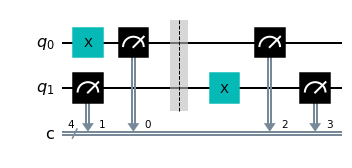

In [7]:
qc_simp.draw(output="mpl")

**NOTE**: In order to store the different measurement results, we must allocate additional memory slots. The Qiskit `measure` command has the syntax `measure(qubits, mem_slots`). In the above circuit, the first measurement is on qubits `[0,1]` and results are stored in memory slots `[0,1]`. The second measurement is on qubits `[0,1]` as well, but the results are stored in memory slots `[2,3]`. 

**If new memory slots are not provided, the old result will be overwritten.**

We expect that state $|01\rangle$ after the first measurement since `x(0)` flips qubit `0` to the $|1\rangle$ state (recall, Qiskit uses little endian bit ordering). We then expect $|11\rangle$ after the second measuremement as `x(1)` flips qubit `1` to the $|1\rangle$ state.

<div class="alert alert-block alert-info">
**Info:**   
The backend will attempt to merge `measure`s on separate qubits following standard commutation rules. This provides significant speedups as the number of measurements scale.
</div>

In [8]:
simp_job = execute(qc_simp, backend=backend)
print(simp_job.job_id())
job_monitor(simp_job)

5ff73f48db39ac7bfc928a32
Job Status: job has successfully run                          


In [9]:
simp_counts1 = marginal_counts(simp_job.result(), indices=[0,1]).get_counts()
simp_counts2 = marginal_counts(simp_job.result(), indices=[2,3]).get_counts()
print("Meas 1 result: ", simp_counts1)
print("Meas 2 result: ", simp_counts2)

Meas 1 result:  {'00': 51, '01': 970, '11': 3}
Meas 2 result:  {'00': 2, '01': 28, '10': 148, '11': 846}


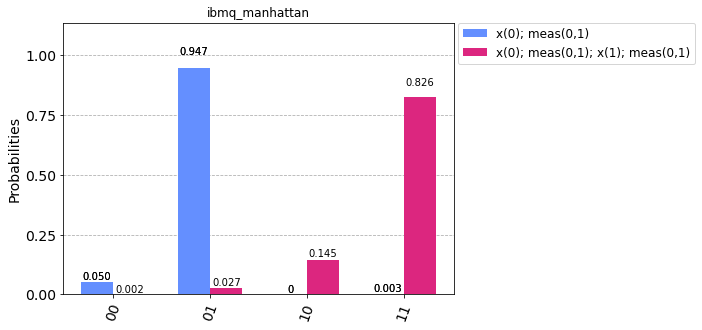

In [10]:
plot_histogram([simp_counts1, simp_counts2], 
               legend=['x(0); meas(0,1)', 'x(0); meas(0,1); x(1); meas(0,1)'],
               title='ibmq_manhattan')

## Single-qubit circuit with reset

Next we combine the ability to `reset` qubits with mid-circuit measurements. This enables qubit reuse and is a first step in providing control flow in the future.

Before reading this section, make sure you are familiar with [conditional reset](https://quantum-computing.ibm.com/docs/manage/backends/reset/backend_reset) on IBM Quantum systems.

In order to use `reset`, we must verify that the backend supports it by checking `supported_instructions`.

In [11]:
assert hasattr(config, 'supported_instructions'), 'Reset is not supported by this backend.'
assert 'reset' in config.supported_instructions, 'Reset is not supported by this backend.'

We perform the sequence `h(0) -> measure(0) -> reset(0) [n times] -> x(0) -> measure(0)`. Without `reset`, we expect 50/50 `0`s and `1`s after both the first measurement and the second measurement. 

However, when the `reset` is included, the superposition prepared by the Hadamard gate is reset to $|0\rangle$. The X gate then flips the state, so after the second measurement we expect all `1`s rather than an even distribution.

In this example, note that we "reuse" the qubit after the first measurement via the `reset` instruction. This provides flexibility in more advanced algorithms.

In [12]:
def h_reset_x_circ(n_resets, qubit=0):
    """Do h, then n_resets reset instructions, then x. 
    
    Two measurements are done--one after the hadamard 
    and one at the end of the circuit.
    Measurement 0 is in memory slot 0. Measurement1 is in
    memory slot 1.
    """
    qc = QuantumCircuit(n_qubits, 2)
    qc.h(qubit)
    qc.measure(qubit, [0])
    qc.reset([qubit]*n_resets)
    qc.x(qubit)
    qc.measure(qubit, [1])
    return qc

We run this experiment on qubits 0, with 0, 1, and 3 `reset`s. We see clear improvement after a single reset and further improvement with 3 resets.

In [13]:
circs_1q = [h_reset_x_circ(0), h_reset_x_circ(1), h_reset_x_circ(3)]

In [14]:
job_1q = execute(circs_1q, backend=backend, optimization_level=0)
print(job_1q.job_id())
job_monitor(job_1q)

5ff7480c266645f47af5d64f
Job Status: job has successfully run                       


In [15]:
counts_1q_1 = marginal_counts(job_1q.result(), indices=[0]).get_counts()
counts_1q_2 = marginal_counts(job_1q.result(), indices=[1]).get_counts()
print("Meas 1 result: ", counts_1q_1)
print("Meas 2 result: ", counts_1q_2)

Meas 1 result:  [{'0': 497, '1': 527}, {'0': 504, '1': 520}, {'0': 573, '1': 451}]
Meas 2 result:  [{'0': 504, '1': 520}, {'0': 101, '1': 923}, {'0': 38, '1': 986}]


After the first measurement, all counts are an equal distribution, as expected. 

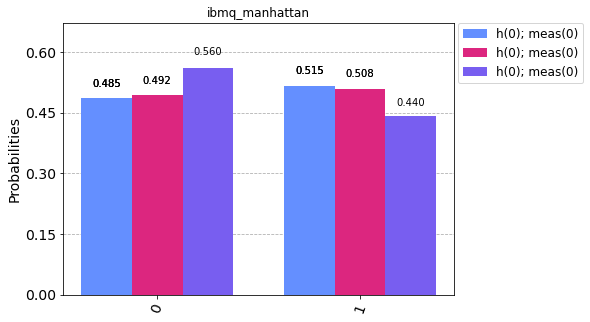

In [16]:
plot_histogram(counts_1q_1, legend=['h(0); meas(0)', 'h(0); meas(0)', 'h(0); meas(0)'], 
               title="ibmq_manhattan")

After the second measurement, however, we observe that the `reset` pushes the counts to all `1`s.

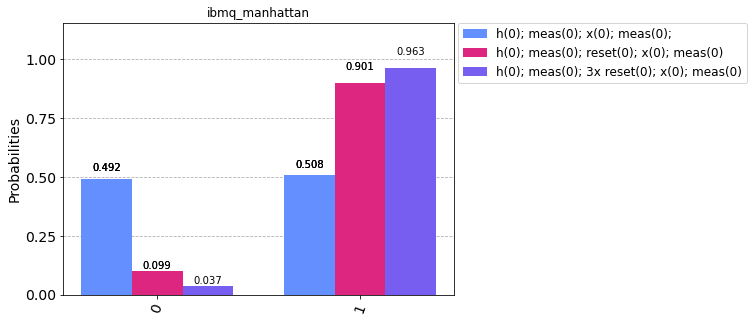

In [17]:
plot_histogram(counts_1q_2, 
               legend=['h(0); meas(0); x(0); meas(0);', 
                       'h(0); meas(0); reset(0); x(0); meas(0)', 
                       'h(0); meas(0); 3x reset(0); x(0); meas(0)'], 
               title="ibmq_manhattan")

## Multi-qubit circuit with reset

This next experiment combines multi-qubit operations with `reset` and mid-circuit measurements. A complex circuit is considered with the possiblity of multiple `reset`s in the middle. The expected result is given by the Aer qasm simulator (it can also be verified analytically). 

Without any `reset`s, we expect the result of the first measurement to be all 50/50 `0`s and `1`s. We expect the result of the second measurement to give nearly equal counts in all 8 possible states. 

With `reset` added, we expect all `1`s after the first measurement and 50/50 counts for the states `010` and `110` after the second measurement.

We run the circuit with 0, 1 and 3 `reset`s. We see an improvement for 1 reset and further improvement for 3 resets.

In [18]:
def multiq_custom_circ(n_resets):
    """Custom multiq circuit w/ many resets."""
    qc = QuantumCircuit(n_qubits, 4)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.reset([0]*n_resets)
    qc.measure(0, 0)
    qc.cx(0, 2)
    qc.reset([1]*n_resets)
    qc.x(1)
    qc.measure([0, 1, 2], [1,2,3])
    return qc

In [19]:
circs_multiq = [multiq_custom_circ(0), multiq_custom_circ(1), multiq_custom_circ(3)]

First we run on the simulator to verify our expected output.

In [20]:
# verify expected output via Aer qasm simulator
sim_job_multiq = execute(circs_multiq, backend=Aer.get_backend('qasm_simulator'), optimization_level=0)
sim_counts_multiq_1 = marginal_counts(sim_job_multiq.result(), indices=[0]).get_counts()
sim_counts_multiq_2 = marginal_counts(sim_job_multiq.result(), indices=[1,2,3]).get_counts()
print("Meas 1 sim result: ", sim_counts_multiq_1)
print("Meas 2 sim result: ", sim_counts_multiq_2)

Meas 1 sim result:  [{'0': 536, '1': 488}, {'0': 1024}, {'0': 1024}]
Meas 2 sim result:  [{'000': 141, '001': 119, '010': 116, '011': 104, '100': 137, '101': 141, '110': 142, '111': 124}, {'010': 518, '110': 506}, {'010': 493, '110': 531}]


In [21]:
legend_multiq_1 = ['h(0,1,2); meas(0);', 
                   'h(0,1,2); reset(0); meas(0);',
                   'h(0,1,2); 3x reset(0); meas(0);']
legend_multiq_2 = ['h(0,1,2); meas(0); cx(0,2); x(1); meas(0,1,2);', 
                   'h(0,1,2); reset(0); meas(0); cx(0,2); reset(1); x(1); meas(0,1,2);', 
                   'h(0,1,2); 3x reset(0); meas(0); cx(0,2); 3x reset(1); x(1); meas(0,1,2);']

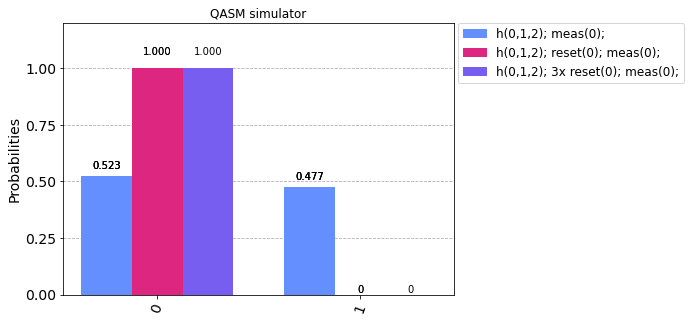

In [22]:
plot_histogram(sim_counts_multiq_1, 
               legend=legend_multiq_1, 
               title="QASM simulator")

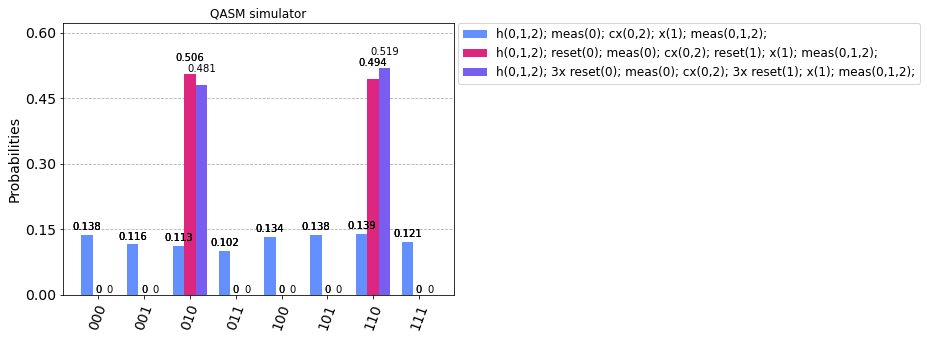

In [23]:
plot_histogram(sim_counts_multiq_2, 
               legend=legend_multiq_2, 
               title="QASM simulator")

Now we run on a real backend.

In [24]:
job_multiq = execute(circs_multiq, backend=backend, optimization_level=0)
print(job_multiq.job_id())
job_monitor(job_multiq)

5ff748720a2d1ce5be694331
Job Status: job has successfully run                       


In [25]:
counts_multiq_1 = marginal_counts(job_multiq.result(), indices=[0]).get_counts()
counts_multiq_2 = marginal_counts(job_multiq.result(), indices=[1,2,3]).get_counts()
print("Meas 1 result: ", counts_multiq_1)
print("Meas 2 result: ", counts_multiq_2)

Meas 1 result:  [{'0': 470, '1': 554}, {'0': 939, '1': 85}, {'0': 991, '1': 33}]
Meas 2 result:  [{'000': 146, '001': 118, '010': 143, '011': 138, '100': 113, '101': 119, '110': 128, '111': 119}, {'000': 54, '001': 2, '010': 440, '011': 43, '100': 36, '101': 6, '110': 411, '111': 32}, {'000': 45, '010': 444, '011': 24, '100': 24, '101': 1, '110': 472, '111': 14}]


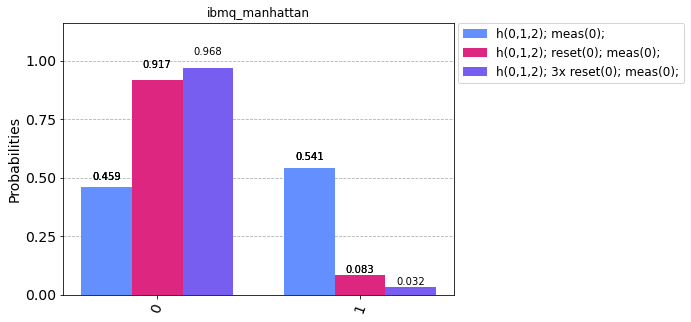

In [26]:
plot_histogram(counts_multiq_1, 
               legend=legend_multiq_1,
               title="ibmq_manhattan")

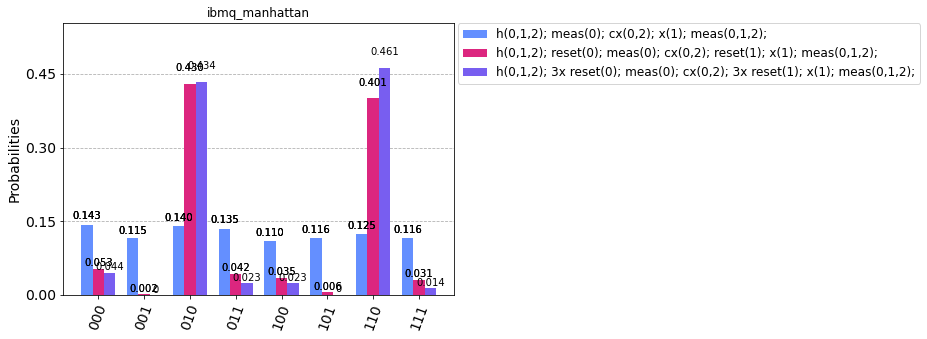

In [27]:
plot_histogram(counts_multiq_2, 
               legend=legend_multiq_2,
               title="ibmq_manhattan")

## GHZ to Bell State

This example uses mid-circuit measurement to demonstrate how to convert GHZ states to Bell states. It also demonstrates how mid-circuit measurements alter the behavior of the quantum state.


Consider the canonical three-qubit GHZ gate: $\frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle\right)$. If one attempts to blindly measure one of the three qubits in the computational (z) basis, then the remaining two qubits are left in an unentangled state. However, by noting that a GHZ state can be written as (ignoring normalization constants):
$$
|000\rangle + |111\rangle = \left[|00\rangle + |11\rangle\right] \otimes \left(|0\rangle+|1\rangle\right) + \left[|00\rangle - |11\rangle\right] \otimes \left(|0\rangle-|1\rangle\right) = \left[|00\rangle + |11\rangle\right] \otimes |+x\rangle + \left[|00\rangle - |11\rangle\right] \otimes |-x\rangle,
$$

we can see that if we make a measurement of any one of the three qubits in the x-basis, then the state of the two remaining qubits is in one of two possible Bell states; that is, the two remaining qubits are still maximally entangled. Given this, it is possible to use interference to transform these Bell states back into the computational basis. The circuit below does this, mapping $\left[|00\rangle + |11\rangle\right] \rightarrow |00\rangle$ and $\left[|00\rangle - |11\rangle\right] \rightarrow |10\rangle$. To explicitly show that measurement is done in the middle, we will flip the flag qubit used to record the result of the x-basis measurement and re-measure. We write the results to different classical bits so both can be displayed.

We use qubit `0` as the flag qubit in our example. For the first measurement, we expect a 50/50 distribution of `0` and `1` (on qubit `0`). For the second measurement, we expect a 50/50 distribution of `001` and `100` states (with little endian ordering).

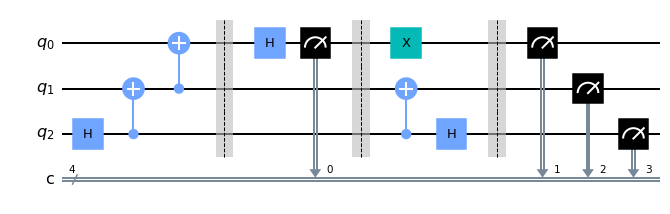

In [28]:
qc_ghz_bell = QuantumCircuit(3, 4)
qc_ghz_bell.h(2)
qc_ghz_bell.cx([2,1], [1,0])
qc_ghz_bell.barrier()
qc_ghz_bell.h(0)
qc_ghz_bell.measure(0, 0)  # w/ h(0) gives meas in x basis
qc_ghz_bell.barrier()
qc_ghz_bell.cx(2, 1)
qc_ghz_bell.h(2)
qc_ghz_bell.x(0)
qc_ghz_bell.barrier()
qc_ghz_bell.measure([0, 1, 2], [1, 2, 3])
qc_ghz_bell.draw('mpl')

First, simulate to verify that we built the circuit correctly.

In [29]:
sim = Aer.get_backend('qasm_simulator')
sim_job_ghz_bell = execute(qc_ghz_bell, sim)
sim_counts_ghz_bell_1 = marginal_counts(sim_job_ghz_bell.result(), indices=[0]).get_counts()
sim_counts_ghz_bell_2 = marginal_counts(sim_job_ghz_bell.result(), indices=[1,2,3]).get_counts()
print("Sim meas 1 result: ", sim_counts_ghz_bell_1)
print("Sim meas 2 result: ", sim_counts_ghz_bell_2)

Sim meas 1 result:  {'0': 508, '1': 516}
Sim meas 2 result:  {'001': 508, '100': 516}


Now we try on real hardware:

In [30]:
job_ghz_bell = execute(qc_ghz_bell, backend, initial_layout=[1,2,3])
print(job_ghz_bell.job_id())
job_monitor(job_ghz_bell)

5ff748df743f6c44934b9c28
Job Status: job has successfully run                       


In [31]:
counts_ghz_bell_1 = marginal_counts(job_ghz_bell.result(), indices=[0]).get_counts()
counts_ghz_bell_2 = marginal_counts(job_ghz_bell.result(), indices=[1,2,3]).get_counts()
print("Meas 1 result: ", counts_ghz_bell_1)
print("Meas 2 result: ", counts_ghz_bell_2)

Meas 1 result:  {'0': 561, '1': 463}
Meas 2 result:  {'000': 155, '001': 201, '010': 23, '011': 41, '100': 156, '101': 379, '110': 30, '111': 39}


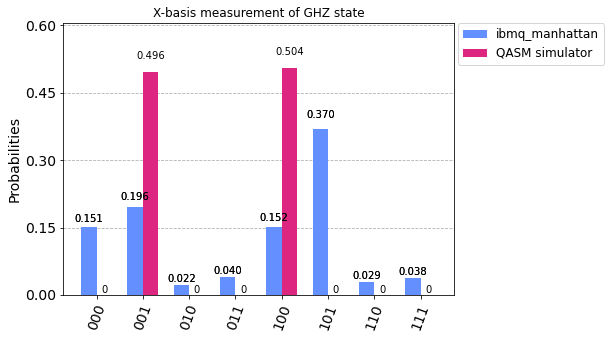

In [32]:
plot_histogram([counts_ghz_bell_2, sim_counts_ghz_bell_2], 
               legend=['ibmq_manhattan', 'QASM simulator'],
               title='X-basis measurement of GHZ state')

Now let's see what happens if we do the first measurement in the computational basis rather than the x basis, destroying the entanglement. Given that the state after the measurement is no longer a Bell pair, we would expect our transformation back to the computational basis to yield a different result.

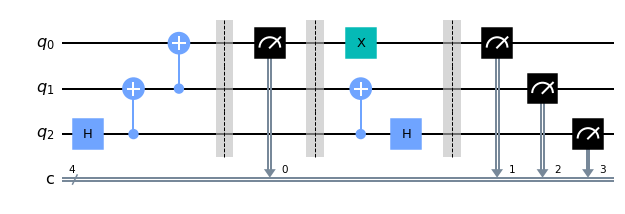

In [33]:
qc_ghz2 = QuantumCircuit(3, 4)
qc_ghz2.h(2)
qc_ghz2.cx([2,1], [1,0])
qc_ghz2.barrier()
qc_ghz2.measure(0, 0)  # measure in z, not x basis
qc_ghz2.barrier()
qc_ghz2.cx(2, 1)
qc_ghz2.h(2)
qc_ghz2.x(0)
qc_ghz2.barrier()
qc_ghz2.measure([0, 1, 2], [1, 2, 3])
qc_ghz2.draw('mpl')

In [34]:
sim_job_ghz2 = execute(qc_ghz2, sim)
sim_counts_ghz2 = marginal_counts(sim_job_ghz2.result(), indices=[1,2,3]).get_counts()
print("Sim meas result: ", sim_counts_ghz2)

Sim meas result:  {'000': 262, '001': 260, '100': 254, '101': 248}


In [35]:
job_ghz2 = execute(qc_ghz2, backend, initial_layout=[1,2,3])
print(job_ghz2.job_id())
job_monitor(job_ghz2)

5ff749435870e1502ea292cc
Job Status: job has successfully run                       


In [36]:
counts_ghz2 = marginal_counts(job_ghz2.result(), indices=[1,2,3]).get_counts()
print("Meas result: ", counts_ghz2)

Meas result:  {'000': 190, '001': 277, '010': 48, '011': 17, '100': 175, '101': 256, '110': 45, '111': 16}


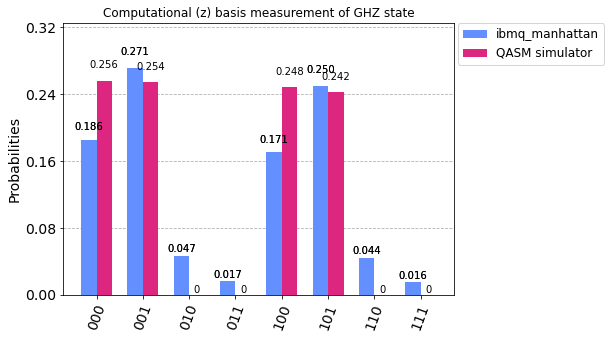

In [37]:
plot_histogram([counts_ghz2, sim_counts_ghz2], 
               legend=['ibmq_manhattan', 'QASM simulator'],
               title='Computational (z) basis measurement of GHZ state')

In [ ]:
%qiskit_copyright